![](../JFM-notebooks-logo.jpg)

In [3]:
import numpy as np
import sys, os, h5py
import matplotlib.pyplot as plt
import seaborn as sns
import cmocean

# Aesthetics
sns.set_theme()
sns.set_style('ticks')
sns.set_context('paper')
plt.rc('mathtext', fontset='stix')
plt.rc('font', family='serif')

cspeed = cmocean.tools.crop_by_percent(cmocean.cm.tempo, 30, which='both', N=None)

import pandas as pd

### Load sheared VC data

In [4]:
df = pd.read_csv('../data/P-VC_global_response.csv')
df.head()

Ra   Pr      Re        Uf        Ub        Uc        UL        nu  \
0  10000000.0  1.0   316.0  1.000000  0.099928  0.110069  0.481715  0.000316   
1  10000000.0  1.0  1000.0  1.000000  0.316228  0.353134  0.532587  0.000316   
2  10000000.0  1.0  1780.0  1.000000  0.562885  0.627192  0.588370  0.000316   
3  10000000.0  1.0  3160.0  1.000000  0.999280  1.115123  0.676748  0.000316   
4  10000000.0  1.0  5620.0  0.562683  1.000000  1.118777  0.439714  0.000178   

       tauu      tauw  ...       Cfw          Rew         Red          Rec  \
0  0.000720  0.010070  ...  0.086788  1523.316245   90.290854   348.068405   
1  0.002316  0.010586  ...  0.074643  1684.188889   99.826188  1116.707042   
2  0.004308  0.011177  ...  0.064573  1860.588872  118.881688  1983.354264   
3  0.008114  0.012164  ...  0.053119  2140.064636  136.738696  3526.327103   
4  0.005193  0.004340  ...  0.044898  2471.801870  157.934933  6289.079322   

         UR      tauR       Red0       Nu0      Cfw0          Re0  
0  0.484970  0.010106  90.901014  13.75895  0.085941  1533.610379  
1  0.484970  0.010106  90.901014  13.75895  0.085941  1533.610379  
2  0.484970  0.010106  90.901014  13.75895  0.085941  1533.610379  
3  0.484970  0.010106  90.901014  13.75895  0.085941  1533.610379  
4  0.272884  0.003200  90.901014  13.75895  0.085941  1533.989069  

[5 rows x 23 columns]

### Load sheared RB data

In [5]:
PRB_df = pd.read_csv('../data/P-RB_global_response.csv')
PRB_df.head()

Averaging time  Bulk Reynolds  Centerline Reynolds  \
0      726.750004           10.0            12.999871   
1      748.600001           20.0            24.962705   
2      719.899999           30.0            37.650986   
3      695.300005           40.0            50.564644   
4      746.150002           50.0            65.820800   

   Friction Reynolds (outfile)  Friction Reynolds (stafield)  \
0                     5.173013                      5.194237   
1                     7.589227                      7.756306   
2                     9.224198                      9.354980   
3                    10.787703                     10.892102   
4                    11.430479                     11.455316   

   Friction Reynolds (std. dev)  Nusselt (out file)  Nusselt (stafield)  \
0                      1.112193           16.192182           16.195277   
1                      0.857962           16.126511           16.125382   
2                      0.792945           16.110101           16.110612   
3                      0.661293           16.100464           16.101657   
4                      0.556352           16.103329           16.101728   

   Nusselt (std. dev)  Prandtl  ...  RMS Reynolds (stafield)  \
0            0.120351      5.0  ...               179.249520   
1            0.108958      5.0  ...               180.061660   
2            0.115645      5.0  ...               182.113507   
3            0.114546      5.0  ...               183.466436   
4            0.123334      5.0  ...               185.737044   

   RMS Reynolds (std. dev)  RMS Spanwise Boundary Layer (stafield)  \
0                 2.316958                                0.094059   
1                 1.968642                                0.090521   
2                 2.346868                                0.090521   
3                 2.596448                                0.090521   
4                 2.529311                                0.101317   

   RMS Spanwise Friction Reynolds (stafield)  \
0                                  67.141265   
1                                  64.576807   
2                                  64.951287   
3                                  64.236294   
4                                  67.195488   

   RMS Spanwise Reynolds (stafield)    Rayleigh       Red0       Cf0  \
0                        131.225401  10000000.0  16.676619  0.381491   
1                        113.948484  10000000.0  16.676619  0.381491   
2                        116.572873  10000000.0  16.676619  0.381491   
3                        110.843101  10000000.0  16.676619  0.381491   
4                        135.949415  10000000.0  16.676619  0.381491   

          Re0        Nu0  
0  179.112719  16.141065  
1  179.112719  16.141065  
2  179.112719  16.141065  
3  179.112719  16.141065  
4  179.112719  16.141065  

[5 rows x 24 columns]

### Define quantities needed ($Gr=Ra/Pr$, $Ri=Gr/Re^2$, $Re_\delta = W_\mathrm{max} \delta/\nu$, $C_f = 2\tau_x/\rho_0 W_\mathrm{max}^2$)

In [6]:
# P-VC
df['Gr'] = df.Ra/df.Pr
df['Ri'] = df.Gr/df.Re**2

# P-RB
PRB_df['Gr'] = PRB_df.Rayleigh/PRB_df.Prandtl
PRB_df['Cf'] = 2*(PRB_df['RMS Spanwise Friction Reynolds (stafield)']/PRB_df['RMS Spanwise Reynolds (stafield)'])**2
PRB_df['Red'] = PRB_df['RMS Spanwise Reynolds (stafield)']*PRB_df['RMS Spanwise Boundary Layer (stafield)']
PRB_df['Ri'] = PRB_df.Gr/PRB_df['Bulk Reynolds']**2

### Write function to solve Prandtl friction law prediction

In [7]:
from scipy.optimize import newton
def Cfunc(Reb):
    Cf = np.zeros(Reb.size)
    for i in range(Reb.size):
        def f(x):
            # k = 0.41
            # B = 5
            k = 0.384
            B = 4.27
            return (2/x)**0.5 - 1/k*np.log(Reb[i]/2*(x/2)**0.5) - B
        Cf[i] = newton(f, 2.5e-3)
    return Cf

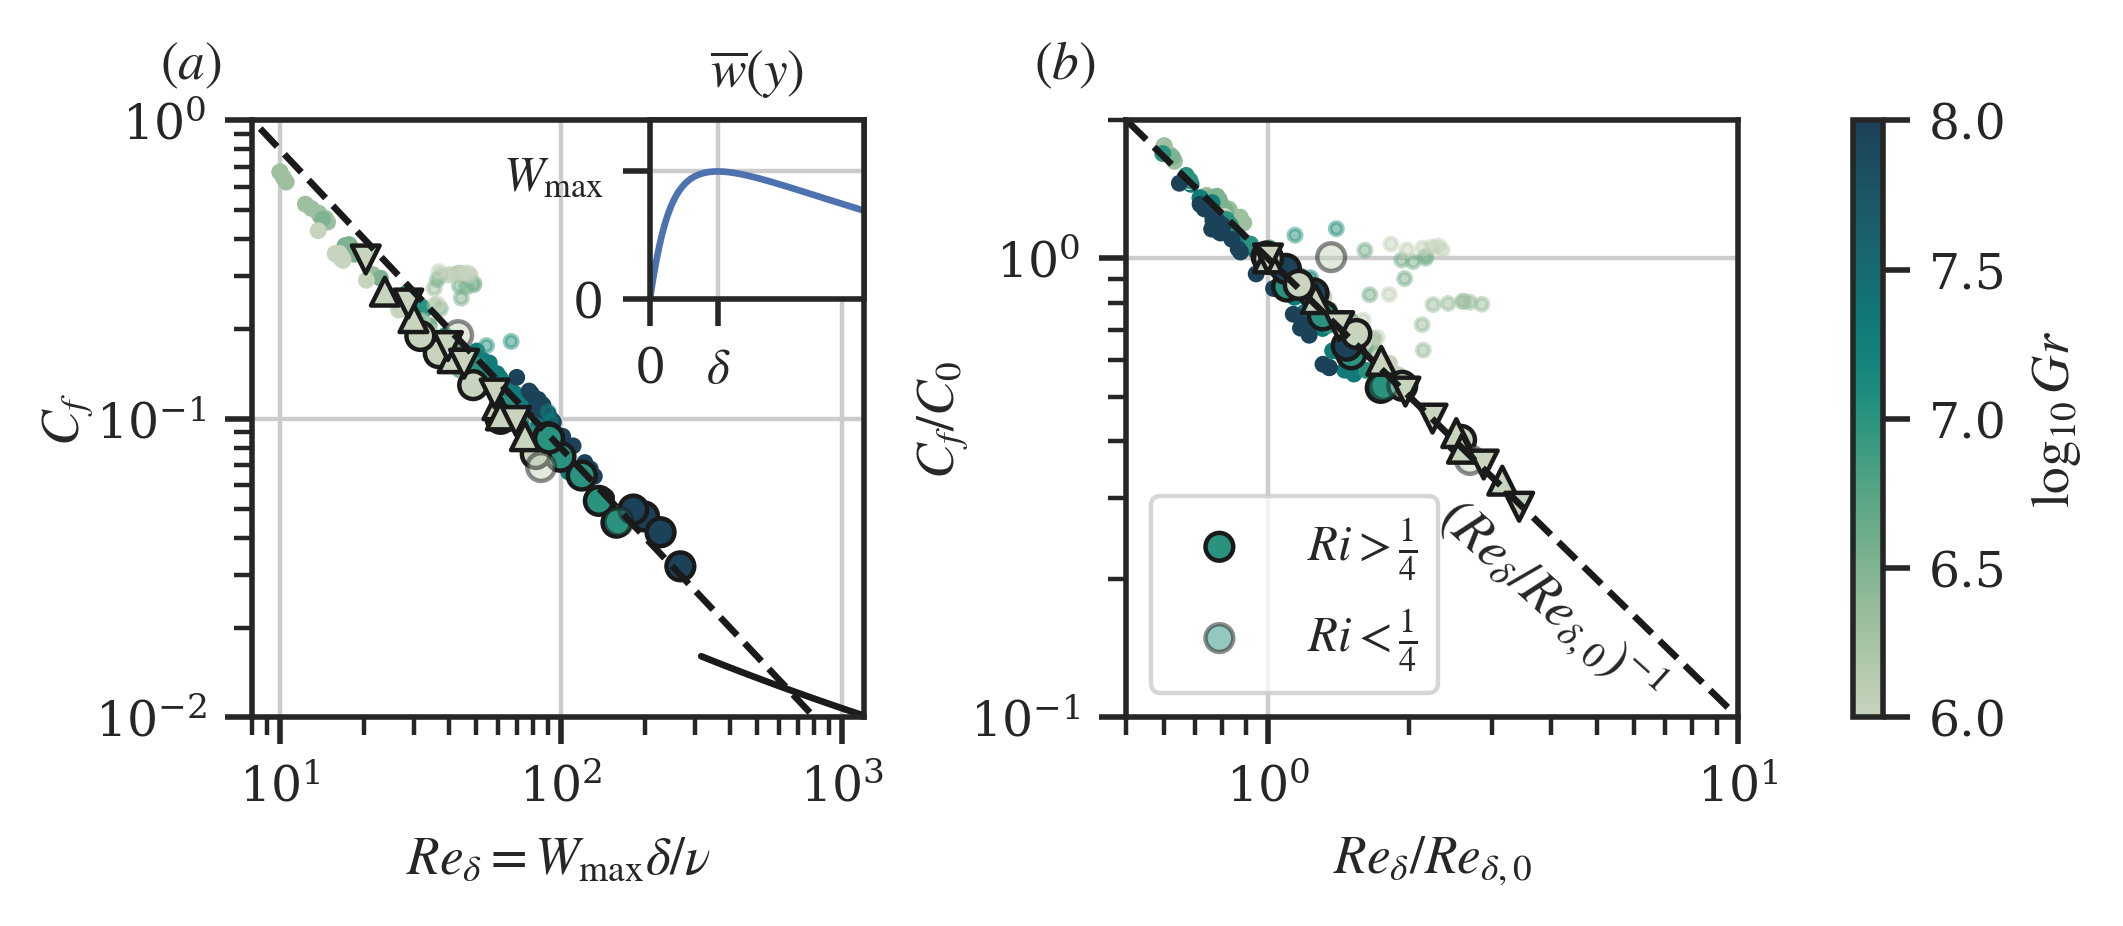

In [8]:
cmap = cspeed
Ric = 0.25 # Richardson number cutoff value

fig, axs = plt.subplots(1,2, figsize=(5.2,2.2), layout='constrained', dpi=200)

ax = axs[0]

# Transparency of low Ri points
alph = 0.5

# P-RB
sc = ax.scatter(PRB_df.Red*(PRB_df.Ri > Ric), PRB_df.Cf*(PRB_df.Ri > Ric), c=np.log10(PRB_df.Gr), cmap=cmap, s=5, label='mixed RB')
ax.scatter(PRB_df.Red*(PRB_df.Ri <= Ric), PRB_df.Cf*(PRB_df.Ri <= Ric), c=np.log10(PRB_df.Gr), cmap=cmap, s=5, label='mixed RB', alpha=alph)

# P-VC
ax.scatter(df.Red*(df.Pr==1)*(df.Ri > Ric), df.Cfw*(df.Pr==1)*(df.Ri > Ric), c=np.log10(df.Gr), cmap=cmap, ec='k', s=25, label='mixed VC')
ax.scatter(df.Red*(df.Pr==1)*(df.Ri <=Ric), df.Cfw*(df.Pr==1)*(df.Ri <=Ric), c=np.log10(df.Gr), cmap=cmap, ec='k', s=25, alpha=alph)
ax.scatter(df.Red*(df.Pr== 4), df.Cfw*(df.Pr== 4), c=np.log10(df.Gr), cmap=cmap, ec='k', s=25, marker='^', vmin=6, vmax=8)
ax.scatter(df.Red*(df.Pr==10), df.Cfw*(df.Pr==10), c=np.log10(df.Gr), cmap=cmap, ec='k', s=25, marker='v', vmin=6, vmax=8)

fig.colorbar(sc, ax=axs, label='$\log_{10} Gr$')

# Add theoretical comparison
R = 10**np.linspace(0.5,3.5,101)
ax.loglog(R, 8*R**-1, 'k--')
R = 10**np.linspace(2.5,3.5,101)
ax.loglog(R, Cfunc(R), 'k-')

# Labels and aesthetics
ax.grid(True)
ax.set(
    xlabel=r'$Re_\delta = W_\mathrm{max}\delta/\nu$',
    ylabel='$C_f$',
    xlim = [8e0,1.2e3],
    ylim=[1e-2,1]
)
ax.set_ylabel('$C_f$', labelpad=0)
ax.annotate('$(a)$', (-0.05, 1.05), xycoords='axes fraction', ha='right', va='bottom')

# Add inset axes for example vertical velocity profile
axin = ax.inset_axes([0.65,0.7,0.35,0.3])

# Load example profile for Gr=10^7, Pr=1, Re=10^{3.5}
with h5py.File('../data/profile_record.h5','r') as fp:
    grp = 'Gr7_Sc1_Re3.50'
    xm = fp[grp+'/xm'][:]
    vybar = fp[grp+'/vybar'][:]

# Use antisymmetry to average profile
n = xm.size
vys = 0.5*(vybar[:n//2] - vybar[-1:-1-n//2:-1])
axin.plot(xm[:n//2], vys)

# Calculate peak velocity and location, adding labels there
vmx = np.max(vys)
xmx = xm[np.argmax(vys)]
axin.set_xticks([0,xmx], labels=['0','$\delta$'])
axin.set_yticks([0,vmx], labels=['0','$W_\mathrm{max}$'], )
axin.set_xlim([0,0.2])
axin.set_ylim(bottom=0, top=1.4*vmx)
axin.set_title('$\overline{w}(y)$')
axin.grid(True)


ax = axs[1]

# P-RB
ax.scatter(PRB_df.Red/PRB_df['Red0']*(PRB_df.Ri > Ric), PRB_df.Cf/PRB_df['Cf0']*(PRB_df.Ri > Ric), c=np.log10(PRB_df.Gr), cmap=cmap, s=5)
ax.scatter(PRB_df.Red/PRB_df['Red0']*(PRB_df.Ri <=Ric), PRB_df.Cf/PRB_df['Cf0']*(PRB_df.Ri <=Ric), c=np.log10(PRB_df.Gr), cmap=cmap, s=5, alpha=alph)

# P-VC
ax.scatter(df.Red/df.Red0*(df.Pr==1)*(df.Ri > Ric), df.Cfw/df.Cfw0*(df.Pr==1)*(df.Ri > Ric), c=np.log10(df.Gr), cmap=cmap, ec='k', s=25, label='$Ri > \\frac{1}{4}$')
ax.scatter(df.Red/df.Red0*(df.Pr==1)*(df.Ri <=Ric), df.Cfw/df.Cfw0*(df.Pr==1)*(df.Ri <=Ric), c=np.log10(df.Gr), cmap=cmap, ec='k', s=25, alpha=alph, label='$Ri < \\frac{1}{4}$')
ax.scatter(df.Red/df.Red0*(df.Pr==4), df.Cfw/df.Cfw0*(df.Pr==4), c=np.log10(df.Gr), cmap=cmap, ec='k', s=25, marker='^')
ax.scatter(df.Red/df.Red0*(df.Pr==10), df.Cfw/df.Cfw0*(df.Pr==10), c=np.log10(df.Gr), cmap=cmap, ec='k', s=25, marker='v')

# Add theoretical comparison
R = 10**np.linspace(-1,1,101)
ax.loglog(R, R**-1, 'k--')

# Labels and aesthetics
ax.grid(True)
ax.legend()
ax.set(
    xlabel=r'$Re_\delta/ Re_{\delta,0}$',
    ylabel='$C_f/ C_0$',
    xlim=[5e-1, 10],
    ylim=[1e-1, 2e0]
)
ax.set_ylabel('$C_f/ C_0$', labelpad=0)
ax.annotate('$(Re_\\delta/Re_{\\delta,0})^{-1}$', (4, 1.8e-1), ha='center', va='center', rotation=-42)
ax.annotate('$(b)$', (-0.05, 1.05), xycoords='axes fraction', ha='right', va='bottom')

# fig.savefig('Convective_friction_coefficients.pdf')

plt.show()